# DTSA 5509 Final Project
## Predicting Walkability of U.S. Counties

#### Rahul Cheeniyil
#### 12-11-2024

In this project, I use the Walkability Index dataset ([published by the U.S. Environmental Protection Agency](https://catalog.data.gov/dataset/walkability-index7)) to build and test supervised learning models to predict walkability of U.S. Census Blocks. Predicting walkability is important for allocating infrastructure funding for areas with low pedestrian accessibility. Improving city walkability can promote for public health and safety as well as reduce automobile traffic and improve environmental health due to reduced emissions.

The models I will use are multilinear regression and gradient boosting. In this report, I will walk through the data I use, how I intend to use it, data cleaning, and exploratory data analysis prior to building the models themselves. Model performance will be assessed at the end of the report.

### Data
The data consists of various metrics from Censis 2019 block groups. The data is accessed by a publicly available API. The code cell below loads the data via REST API requests and loads it into a Pandas DataFrame. The resulting DataFrame has 220,134 rows and 182 columns. Each row corresponds to a U.S. Census Block and each column responds to a metric associated with that block. The column "NatWalkInd" is the National Walkability Index score assigned to the block. This is the metric I will be predicting with machine learning models. All other columns reflect various metrics/statistics associated with the block. These 181 columns can be grouped into several categories.
- Geographic Identifiers: Spatial and administrative context for identifying the blocks
- Population and Demographics: Population of the block and various demographic distributions.
- Automobile Ownership Statistics: Car ownership/dependency of residents including percentage of households owning different numbers of vehicles.
- Employment and Wages: Job distributions and wage levels.
- Land Use and Density: Metrics related to the land itself.
- Transportation: Proximity to destinations and transit.
- Environmental Metrics: Assessments of emissions and vehicle usage.
- Geographic Measurements: Geometric characterization of the land.

In [2]:
import requests
import pandas as pd

# Publicly accessibly Esri REST API Endpoint
api_url = "https://geodata.epa.gov/arcgis/rest/services/OA/WalkabilityIndex/MapServer/0/query"

params = {
    "where": "1=1",  # Select all records
    "outFields": "*",  # Retrieve all fields
    "f": "json",  # Response format
    "resultRecordCount": 10000,  # Limit to 10000 records per request to avoid rate limits
    "returnGeometry": True,  # Include geographic data such as area/perimeter of census blocks
}

# Fetch the data in chunks
def fetch_data(api_url, params):
    offset = 0
    all_data = []

    while True:
        params["resultOffset"] = offset
        response = requests.get(api_url, params=params)

        if response.status_code == 200:
            data = response.json()
            features = data.get("features", [])
            
            if not features:
                break  # No more records
            
            all_data.extend([feature["attributes"] for feature in features])
            
            offset += len(features)
        else:
            print(f"Error: {response.status_code}")
            break

    return pd.DataFrame(all_data)

walkability_data = fetch_data(api_url, params)  # This took me about 7 minutes to run.

print(walkability_data.info)

# Report memory usage in MB
memory_B = walkability_data.memory_usage(deep=True).sum()
memory_MB = round(memory_B/1024/1024, 3)
print(f"The Complete DataFrame size is {memory_MB:,} MB.")


<bound method DataFrame.info of              GEOID10       GEOID20 STATEFP COUNTYFP TRACTCE BLKGRPCE   CSA   
0       481130078254  481130078254      48      113  007825        4   206  \
1       481130078252  481130078252      48      113  007825        2   206   
2       481130078253  481130078253      48      113  007825        3   206   
3       481130078241  481130078241      48      113  007824        1   206   
4       481130078242  481130078242      48      113  007824        2   206   
...              ...           ...     ...      ...     ...      ...   ...   
220129  780309610002  780309610002      78      030  961000        2  None   
220130  780309610003  780309610003      78      030  961000        3  None   
220131  780309610005  780309610005      78      030  961000        5  None   
220132  780309607003  780309607003      78      030  960700        3  None   
220133  780309602002  780309602002      78      030  960200        2  None   

                        CSA_Nam

### Data Cleaning
Upon examining the column data, it's fairly clear that not all are needed to build a model. Primary features of interest are going to be quantifiable, meaning we can drop all of our non-numeric datatype columns. Additionally, examining our column groupings, we likely don't need any administrative information or other identifiers, so it's safe to drop those columns. I also drop redudant columns that effecively show duplicate data that is presented differently. This could bias the models to more strongly depends on duplicated data. We can also discard any columns providing a "score" other than our target dependent variable "NatWalkInd." Scores are results from assessments and are not realistic to include in a model that is meant to infer walkability based on measurable metrics. From the remaining dataframe, I drop any rows with None or NaN values to ensure useability of data. After these steps, the data should be clean and usable for building a model. Many columns still remain, but those will be filtered down further after investigating which features best suit my models through EDA.

Remaining data size is 217,181 rows and 146 columns taking up 243.574 MB in memory.

In [3]:
# Remove columns with non-numeric values
numeric_walkability_data = walkability_data.select_dtypes(include=['number'])

# Manually drop columns with data irrelevant to model training
columns_to_drop = [
    "OBJECTID",  # Unique object identifier
    "Shape_Length",  # Metadata about polygons for mapping
    "Shape_Area",
    "Households",  # Redundant general counts already covered by more detailed columns
    "Residents",
    "Workers_1",
    "Drivers",
    "Vehicles",
    "SLC_score",  # Scores that are higher-level aggregations - not independent variables
    "D2A_Ranked",
    "D2B_Ranked",
    "D3B_Ranked",
    "D4A_Ranked",
    "B_C_*",  # Coefficients derived from statistical or predictive models of the population
    "B_N_*",
    "C_R_*",
    "GHG_per_worker", # Metrics focused on vehicle usage/emissions, likely resulting from vehicle ownership 
    "Annual_GHG",
    "NonCom_VMT_Per_Worker",
    "Com_VMT_Per_Worker",
    "VMT_per_worker",
    "logd1a",  # Log/Scaled transformations of existing variables
    "logd1c",
    "logd3aao",
    "logd3apo",
    "logd4d",
    "d4bo25",
    "d5dei_1"
]

filtered_walkability_data = numeric_walkability_data.drop(columns=columns_to_drop, errors='ignore')

# Filter out rows with missing data
cleaned_walkability_data = filtered_walkability_data.dropna()

print(cleaned_walkability_data.info)

memory_B = cleaned_walkability_data.memory_usage(deep=True).sum()
memory_MB = round(memory_B/1024/1024, 3)
print(f"The Cleaned DataFrame size is {memory_MB:,} MB.")

del walkability_data, numeric_walkability_data, filtered_walkability_data  # Free up memory taken by large intermediate DataFrames

<bound method DataFrame.info of         CBSA_POP  CBSA_EMP  CBSA_WRK       Ac_Total    Ac_Water   
0        7189384   3545715   3364458      73.595028    0.000000  \
1        7189384   3545715   3364458     119.829909    0.000000   
2        7189384   3545715   3364458      26.367053    0.000000   
3        7189384   3545715   3364458     119.060687    0.000000   
4        7189384   3545715   3364458     169.927211    0.000000   
...          ...       ...       ...            ...         ...   
217177     80610     39570     37773     193.420737    0.000000   
217178     80610     39570     37773     495.303549   44.102902   
217179     80610     39570     37773     126.513965    0.000000   
217180         0         0         0  367912.651157  810.976517   
217181         0         0         0  914821.703629  423.499748   

              Ac_Land        Ac_Unpr  TotPop  CountHU     HH  ...   
0           73.595028      73.595028    1202    460.0  423.0  ...  \
1          119.829909    

### Exploratory Data Analysis (EDA)
##### Plan
The data is now ready for exploratory data analysis (EDA). The goal here is to identify a set of predictors that could have value as features in the machine learning models. First steps here is to investigate some common visualizations such as KDE plots to check for variable distributions and correlation meatmaps to get a bearing of predictor quality.

##### Discussion
Initial visualizatiosn and assessment of feature quality was done by examining correlation with the dependent variable NatWalkInd and checking for quality of the predictors. I set a correlation threshold of 0.5 in either positive or negative direction to qualify features. This filter left us with 13 columns which is a pretty big reduction from the 146 after data cleaning. Further visualization with the correlation matrix shows that a couple sets of predictors are perfectly correlated and would be redundant to include in a model.

The features D5DRI, D5DEI, D5DR, D5DE, and D4A all reflect highly similar measures of destination accessibility quantifications, so excluding all but D4A is a reasonable choice. D4D, D4C, and D4E also reflect highly similar active transporation metrics so I also exlude all but D4C. Since the columns I eliminate appear to be perfectly redundant, I didn't have a reason for keeping the columns that I did other than that they are alphabetically first. Removing redundant features leaves us with 7 remaining predictors that do not appear to have any codependence.

The KDE plot does show certain features to be highly bimodal and also shows some skewed distributions. This indicates that a non-linear model such as a Random Forest or Gradient Boosting will be able to better predict outcomes than a simple regression model.

After visualizations, I ran a check for multicollinearity and found that D3A and D3APO were highly collinear, so I decided to drop D3APO as D3A has a higher correlation with NatWalkInd. This leaves us with a final dataset for model building of 7 rows (6 predictors) and 217,182 rows.

NatWalkInd    1.000000
D5DRI         0.833210
D5DEI         0.833210
D5DR          0.833209
D5DE          0.833209
D4A           0.832624
D3A           0.768176
D4D           0.709511
D4C           0.709149
D4E           0.709107
D3APO         0.699990
D3B           0.662435
D3BPO3        0.512583
D5BE          0.502522
Name: NatWalkInd, dtype: float64


Text(0.5, 1.02, 'KDE Matrix Plot of Strongly Correlated Feeatures')

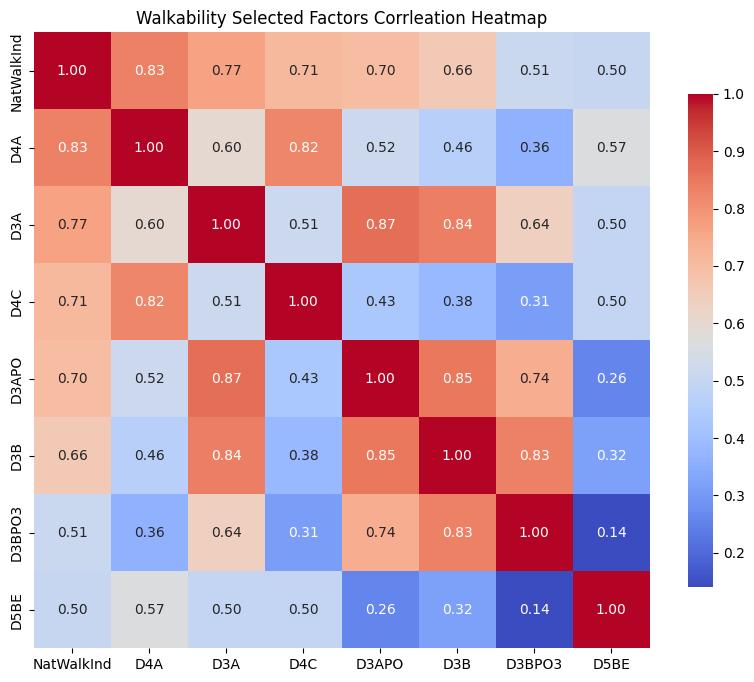

<Figure size 1200x1200 with 0 Axes>

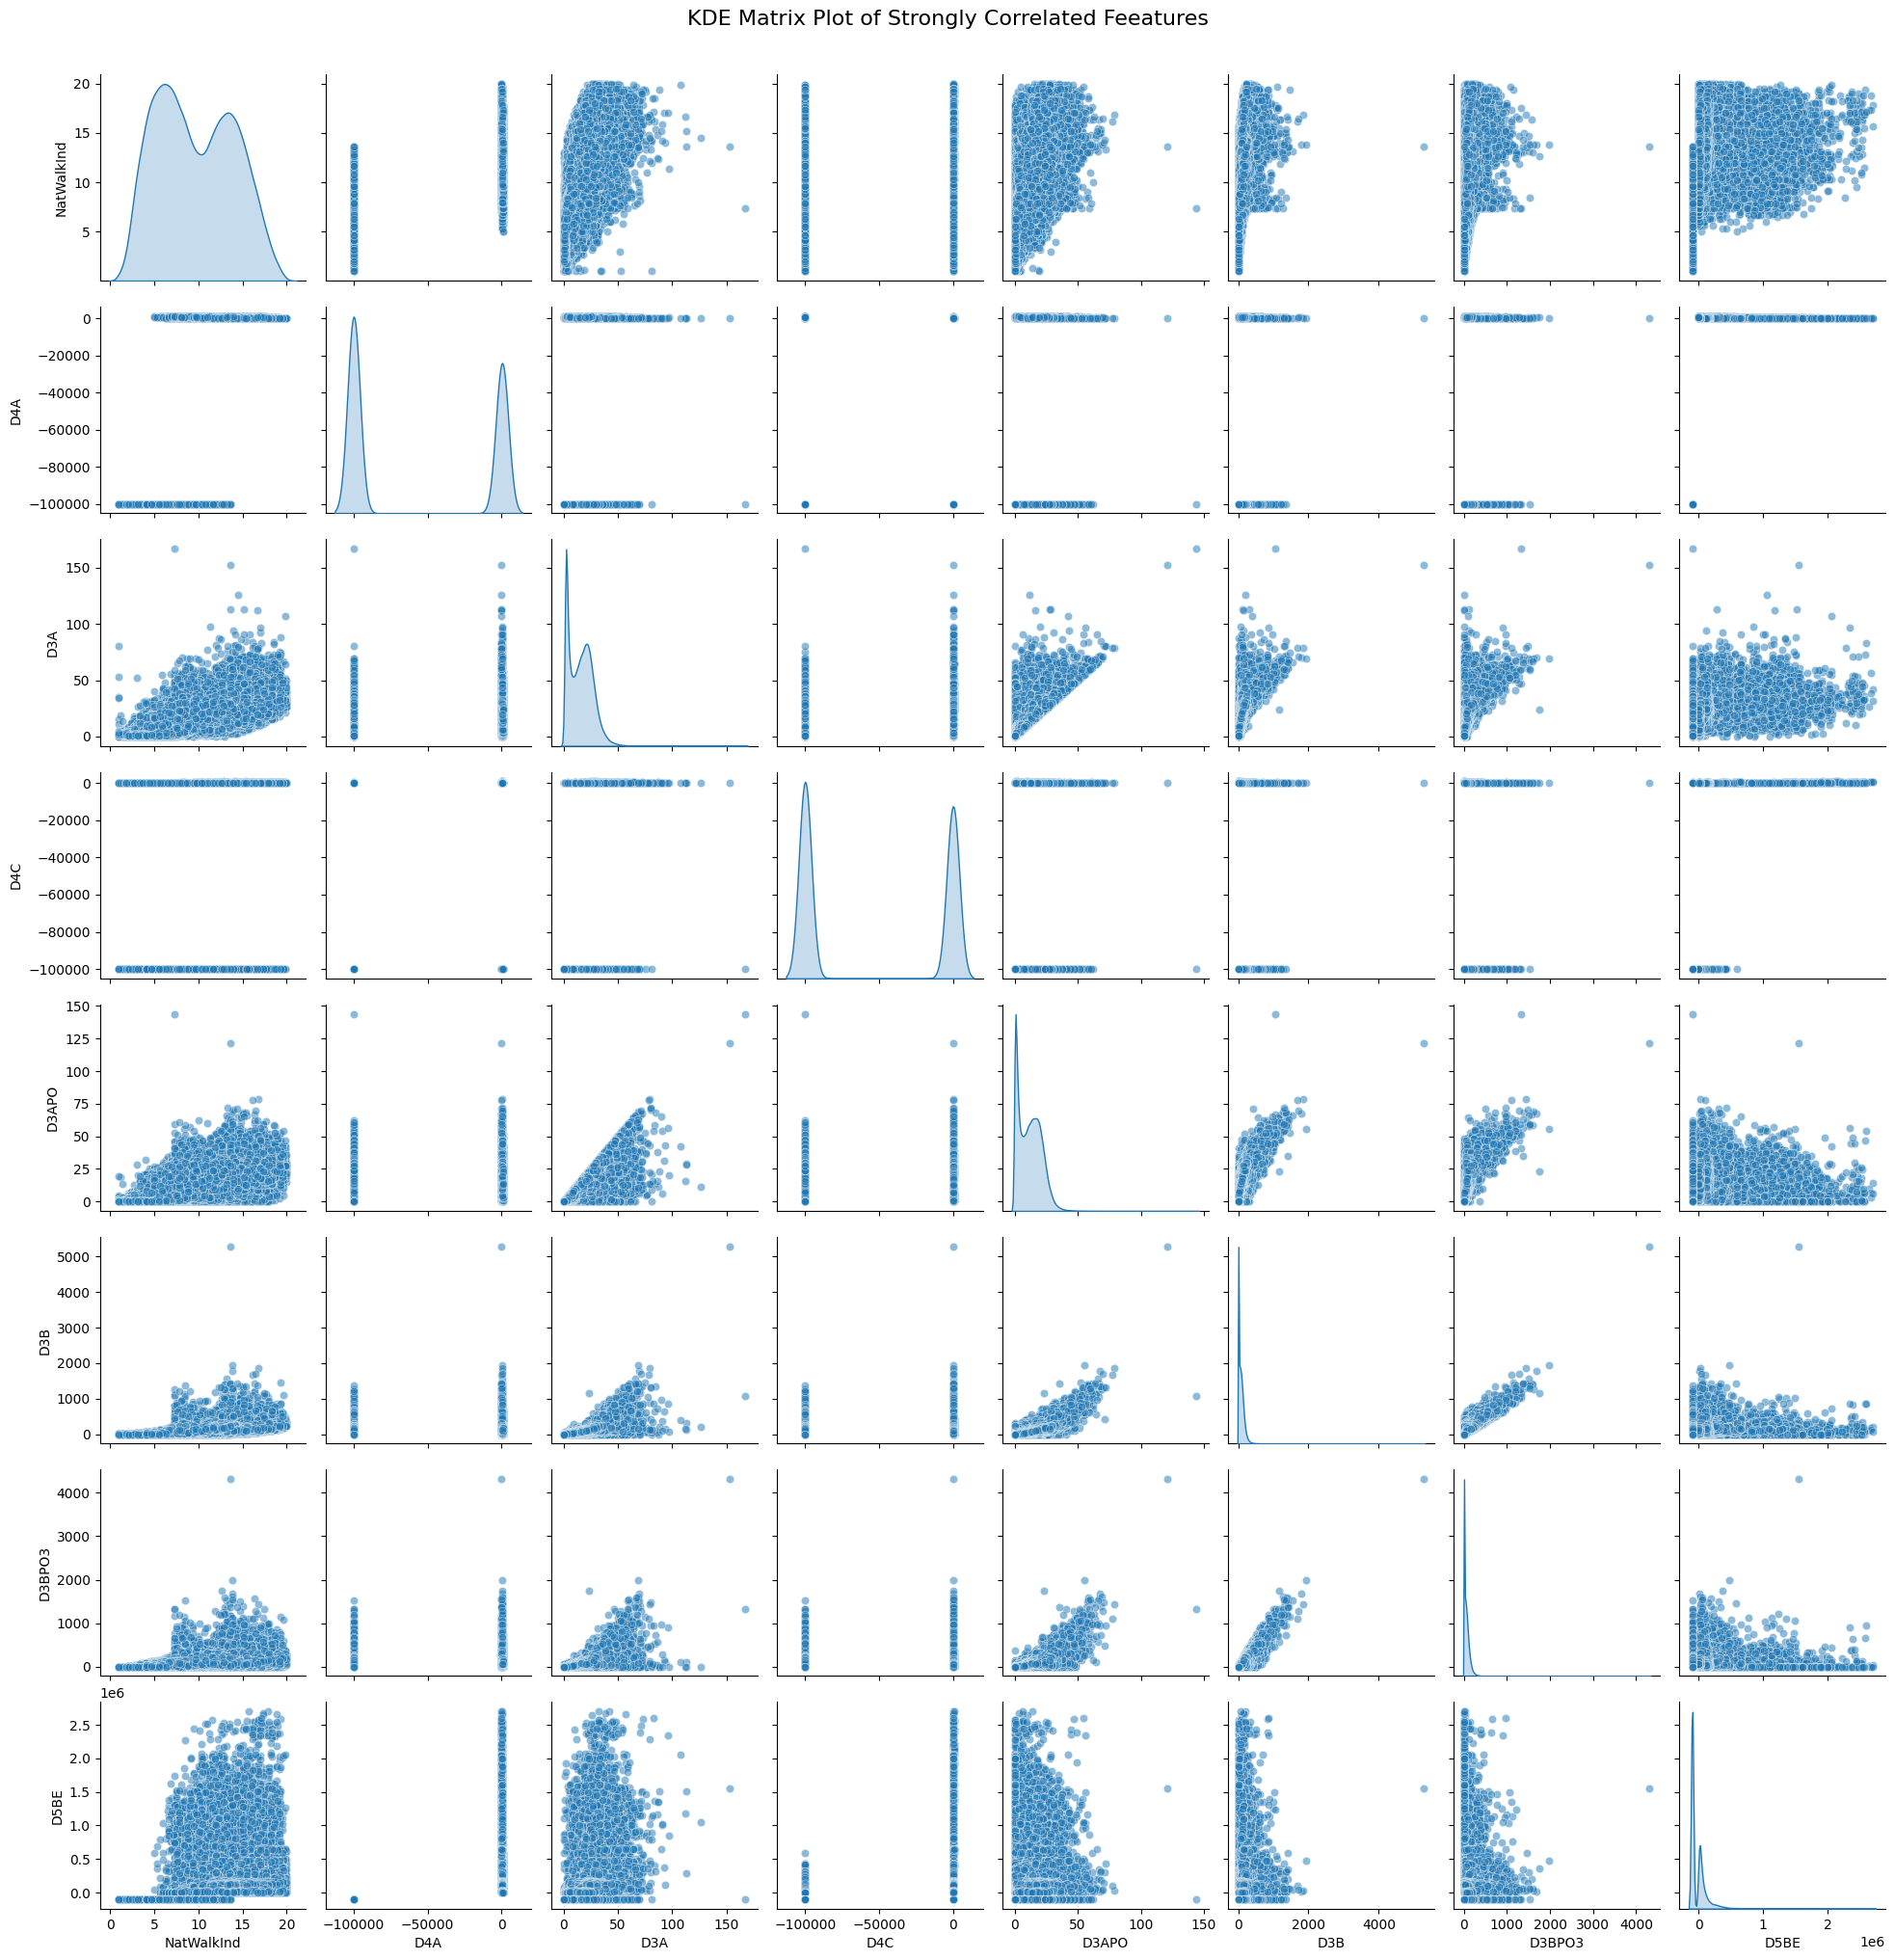

In [21]:
import seaborn as sns
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 999)  # Increase max number of columns/rows shown to increase readability of printouts
pd.set_option('display.max_rows', 999)

# Specifically print correlations with our target dependent variable
corr_matrix = cleaned_walkability_data.corr()
natwalkind_corr = corr_matrix["NatWalkInd"].sort_values(ascending=False)

# Want to examine factors with a "strong" correlation, we'll use the threshold of 0.5 here in either the positive or negative direction
threshold = 0.5
strong_corr = natwalkind_corr[abs(natwalkind_corr) >= threshold]
print(strong_corr)

# Save strongly correlated features
strong_cols = strong_corr.index.to_list()

# Need to drop some features because of redundancy
features_to_drop = ["D5DRI", "D5DEI", "D5DR", "D5DE", "D4D", "D4E"]
strong_cols = [col for col in strong_cols if col not in features_to_drop]
features_df = cleaned_walkability_data[strong_cols]
features_corr_matrix = features_df.corr()

# Heatmap to visualize
plt.figure(figsize=(10, 8))
sns.heatmap(features_corr_matrix,
            annot=True,
            cmap='coolwarm',
            fmt='.2f',
            square=True,
            cbar_kws={'shrink': 0.8})
plt.title('Walkability Selected Factors Corrleation Heatmap')

# KDE plot to check selected variable distributions
plt.figure(figsize=(12, 12))
sns.pairplot(features_df,
             diag_kind='kde',
             plot_kws={'alpha': 0.5},
             diag_kws={'fill': True})
plt.suptitle("KDE Matrix Plot of Strongly Correlated Feeatures",
             y=1.02,
             fontsize=16)

In [27]:
# Need to check for multicollinearity by getting VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

predictors = features_df.drop(columns=["NatWalkInd"])

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = predictors.columns
vif_data["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]

print(vif_data)

# Drop an additional column due to high VIF
predictors = predictors.drop(columns=["D3APO"])

# Recalculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = predictors.columns
vif_data["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]

print()  # print an extra line break for readability
print(vif_data)

final_features_df = features_df.drop(columns=["D3APO"])

  Feature        VIF
0     D4A   7.061964
1     D3A  17.950515
2     D4C   6.603426
3   D3APO  17.361835
4     D3B  12.314492
5  D3BPO3   6.095355
6    D5BE   1.925738

  Feature        VIF
0     D4A   7.014708
1     D3A   7.775423
2     D4C   6.595187
3     D3B  11.939816
4  D3BPO3   5.820051
5    D5BE   1.685860
